### based on
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/1.0-determine-categorical-units.ipynb
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/analyze-spike-shape.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1)

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [5]:
from cdcp.visualization.colors import nuclei_dict
from scipy import interpolate

In [6]:
%matplotlib inline

In [7]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    ('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    ('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    ('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    ('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [9]:
identifiers = ['spike_count',  "nm_by_interpolation_16_25"]# , 

In [10]:
n_interp_bins = 16

In [11]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/14 [00:00<?, ?it/s]

B1597 nrows per [6750, 6750]
B1188 nrows per [510, 510]
B1595 nrows per [242, 242]
B1276 nrows per [46, 46]
B1426 nrows per [93, 93]
B1432 nrows per [2157, 2157]
B1170 nrows per [1281, 1281]
B1244 nrows per [141, 141]
B1593 nrows per [7714, 7714]
B1248 nrows per [8698, 8698]
B1279 nrows per [827, 827]
B1500 nrows per [307, 307]
B1239 nrows per [206, 206]
B1459 nrows per [447, 447]


In [12]:
unit_statistics_df = unit_statistics_df[unit_statistics_df.n_trials > 1000]

In [13]:
len(unit_statistics_df)

29230

In [14]:
unit_statistics_df[:3]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,sm_correlation_AF,rv_AF,ips_AF,nm_min_correlation_AF,nm_max_correlation_AF,nm_r2_correlation_AF,nm_inflection_correlation_AF,nm_slope_correlation_AF,nm_range_correlation_AF,nm_scaled_slope_correlation_AF,sm_cosine_AF,nm_min_cosine_AF,nm_max_cosine_AF,nm_r2_cosine_AF,nm_inflection_cosine_AF,nm_slope_cosine_AF,nm_range_cosine_AF,nm_scaled_slope_cosine_AF,sm_euclidean_AF,nm_min_euclidean_AF,nm_max_euclidean_AF,nm_r2_euclidean_AF,nm_inflection_euclidean_AF,nm_slope_euclidean_AF,nm_range_euclidean_AF,nm_scaled_slope_euclidean_AF,sm_manhattan_AF,nm_min_manhattan_AF,nm_max_manhattan_AF,nm_r2_manhattan_AF,nm_inflection_manhattan_AF,nm_slope_manhattan_AF,nm_range_manhattan_AF,nm_scaled_slope_manhattan_AF,sm_correlation_AE,rv_AE,ips_AE,nm_min_correlation_AE,nm_max_correlation_AE,nm_r2_correlation_AE,nm_inflection_correlation_AE,nm_slope_correlation_AE,nm_range_correlation_AE,nm_scaled_slope_correlation_AE,sm_cosine_AE,nm_min_cosine_AE,nm_max_cosine_AE,nm_r2_cosine_AE,nm_inflection_cosine_AE,nm_slope_cosine_AE,nm_range_cosine_AE,nm_scaled_slope_cosine_AE,sm_euclidean_AE,nm_min_euclidean_AE,nm_max_euclidean_AE,nm_r2_euclidean_AE,nm_inflection_euclidean_AE,nm_slope_euclidean_AE,nm_range_euclidean_AE,nm_scaled_slope_euclidean_AE,sm_manhattan_AE,nm_min_manhattan_AE,nm_max_manhattan_AE,nm_r2_manhattan_AE,nm_inflection_manhattan_AE,nm_slope_manhattan_AE,nm_range_manhattan_AE,nm_scaled_slope_manhattan_AE,sm_correlation_BF,rv_BF,ips_BF,nm_min_correlation_BF,nm_max_correlation_BF,nm_r2_correlation_BF,nm_inflection_correlation_BF,nm_slope_correlation_BF,nm_range_correlation_BF,nm_scaled_slope_correlation_BF,sm_cosine_BF,nm_min_cosine_BF,nm_max_cosine_BF,nm_r2_cosine_BF,nm_inflection_cosine_BF,nm_slope_cosine_BF,nm_range_cosine_BF,nm_scaled_slope_cosine_BF,sm_euclidean_BF,nm_min_euclidean_BF,nm_max_euclidean_BF,nm_r2_euclidean_BF,nm_inflection_euclidean_BF,nm_slope_euclidean_BF,nm_range_euclidean_BF,nm_scaled_slope_euclidean_BF,sm_manhattan_BF,nm_min_manhattan_BF,nm_max_manhattan_BF,nm_r2_manhattan_BF,nm_inflection_manhattan_BF,nm_slope_manhattan_BF,nm_range_manhattan_BF,nm_scaled_slope_manhattan_BF,sm_correlation_BE,rv_BE,ips_BE,nm_min_correlation_BE,nm_max_correlation_BE,nm_r2_correlation_BE,nm_inflection_correlation_BE,nm_slope_correlation_BE,nm_range_correlation_BE,nm_scaled_slope_correlation_BE,sm_cosine_BE,nm_min_cosine_BE,nm_max_cosine_BE,nm_r2_cosine_BE,nm_inflection_cosine_BE,nm_slope_cosine_BE,nm_range_cosine_BE,nm_scaled_slope_cosine_BE,sm_euclidean_BE,nm_min_euclidean_BE,nm_max_euclidean_BE,nm_r2_euclidean_BE,nm_inflection_euclidean_BE,nm_slope_euclidean_BE,nm_range_euclidean_BE,nm_scaled_slope_euclidean_BE,sm_manhattan_BE,nm_min_manhattan_BE,nm_max_manhattan_BE,nm_r2_manhattan_BE,nm_inflection_manhattan_BE,nm_slope_manhattan_BE,nm_range_manhattan_BE,nm_scaled_slope_manhattan_BE,sm_correlation_CG,rv_CG,ips_CG,nm_min_correlation_CG,nm_max_correlation_CG,nm_r2_correlation_CG,nm_inflection_correlation_CG,nm_slope_correlation_CG,nm_range_correlation_CG,nm_scaled_slope_correlation_CG,sm_cosine_CG,nm_min_cosine_CG,nm_max_cosine_CG,nm_r2_cosine_CG,nm_inflection_cosine_CG,nm_slope_cosine_CG,nm_range_cosine_CG,nm_scaled_slope_cosine_CG,sm_euclidean_CG,nm_min_euclidean_CG,nm_max_euclidean_CG,nm_r2_euclidean_CG,nm_inflection_euclidean_CG,nm_slope_euclidean_CG,nm_range_euclidean_CG,nm_scaled_slope_euclidean_CG,sm_manhattan_CG,nm_min_manhattan_CG,nm_max_manhattan_CG,nm_r2_manhattan_CG,nm_inflection_manhattan_CG,nm_slope_manhattan_CG,nm_range_manhattan_CG,nm_scaled_slope_manhattan_CG,sm_correlation_AG,rv_AG,ips_AG,nm_min_correlation_AG,nm_max_correlation_AG,nm_r2_correlation_AG,nm_inflection_correlation_AG,nm_slope_correlation_AG,nm_range_correlation_AG,nm_scaled_slope_correlation_AG,sm_cosine_AG,nm_min_cosine_AG,nm_max_cosine_AG,nm_r2_cosine_AG,nm_inflection_cosine_AG,nm_slope_cosine_AG,nm_range_cosine_AG,nm_scaled_slope_cosine_

### Merge with template info

In [15]:
template_info = pd.read_pickle(DATA_DIR / 'spike_shape' / 'template-info-11-14-21.pickle')

In [16]:
template_info[:3]

,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,bird,unit
2,"[22.0, 22.05905905905906, 22.11811811811812, 2...","[0.04386099708032402, 0.04397874204473111, 0.0...",NCL,2420.0,2717.25,-722.499502,-365.75,365.649900,18.982587,64.0,35,B1597,982
7,"[39.75, 39.528528528528525, 39.30705705705706,...","[0.05518305414255926, 0.05487559572240221, 0.0...",Field_L,2420.0,2544.25,-822.499502,-559.75,559.589339,10.697164,72.0,38,B1597,11599
8,"[27.0, 27.11811811811812, 27.236236236236238, ...","[0.03453874708847825, 0.03468984530359857, 0.0...",NCL,2420.0,2924.25,-762.499502,-587.00,586.815816,0.633780,60.0,36,B1597,6067


In [17]:
len(unit_statistics_df), len(template_info)

(29230, 14406)

In [18]:
unit_statistics_df = unit_statistics_df.merge(template_info, on = ["unit", "bird"])

In [19]:
unit_statistics_df[:3]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,sm_correlation_AF,rv_AF,ips_AF,nm_min_correlation_AF,nm_max_correlation_AF,nm_r2_correlation_AF,nm_inflection_correlation_AF,nm_slope_correlation_AF,nm_range_correlation_AF,nm_scaled_slope_correlation_AF,sm_cosine_AF,nm_min_cosine_AF,nm_max_cosine_AF,nm_r2_cosine_AF,nm_inflection_cosine_AF,nm_slope_cosine_AF,nm_range_cosine_AF,nm_scaled_slope_cosine_AF,sm_euclidean_AF,nm_min_euclidean_AF,nm_max_euclidean_AF,nm_r2_euclidean_AF,nm_inflection_euclidean_AF,nm_slope_euclidean_AF,nm_range_euclidean_AF,nm_scaled_slope_euclidean_AF,sm_manhattan_AF,nm_min_manhattan_AF,nm_max_manhattan_AF,nm_r2_manhattan_AF,nm_inflection_manhattan_AF,nm_slope_manhattan_AF,nm_range_manhattan_AF,nm_scaled_slope_manhattan_AF,sm_correlation_AE,rv_AE,ips_AE,nm_min_correlation_AE,nm_max_correlation_AE,nm_r2_correlation_AE,nm_inflection_correlation_AE,nm_slope_correlation_AE,nm_range_correlation_AE,nm_scaled_slope_correlation_AE,sm_cosine_AE,nm_min_cosine_AE,nm_max_cosine_AE,nm_r2_cosine_AE,nm_inflection_cosine_AE,nm_slope_cosine_AE,nm_range_cosine_AE,nm_scaled_slope_cosine_AE,sm_euclidean_AE,nm_min_euclidean_AE,nm_max_euclidean_AE,nm_r2_euclidean_AE,nm_inflection_euclidean_AE,nm_slope_euclidean_AE,nm_range_euclidean_AE,nm_scaled_slope_euclidean_AE,sm_manhattan_AE,nm_min_manhattan_AE,nm_max_manhattan_AE,nm_r2_manhattan_AE,nm_inflection_manhattan_AE,nm_slope_manhattan_AE,nm_range_manhattan_AE,nm_scaled_slope_manhattan_AE,sm_correlation_BF,rv_BF,ips_BF,nm_min_correlation_BF,nm_max_correlation_BF,nm_r2_correlation_BF,nm_inflection_correlation_BF,nm_slope_correlation_BF,nm_range_correlation_BF,nm_scaled_slope_correlation_BF,sm_cosine_BF,nm_min_cosine_BF,nm_max_cosine_BF,nm_r2_cosine_BF,nm_inflection_cosine_BF,nm_slope_cosine_BF,nm_range_cosine_BF,nm_scaled_slope_cosine_BF,sm_euclidean_BF,nm_min_euclidean_BF,nm_max_euclidean_BF,nm_r2_euclidean_BF,nm_inflection_euclidean_BF,nm_slope_euclidean_BF,nm_range_euclidean_BF,nm_scaled_slope_euclidean_BF,sm_manhattan_BF,nm_min_manhattan_BF,nm_max_manhattan_BF,nm_r2_manhattan_BF,nm_inflection_manhattan_BF,nm_slope_manhattan_BF,nm_range_manhattan_BF,nm_scaled_slope_manhattan_BF,sm_correlation_BE,rv_BE,ips_BE,nm_min_correlation_BE,nm_max_correlation_BE,nm_r2_correlation_BE,nm_inflection_correlation_BE,nm_slope_correlation_BE,nm_range_correlation_BE,nm_scaled_slope_correlation_BE,sm_cosine_BE,nm_min_cosine_BE,nm_max_cosine_BE,nm_r2_cosine_BE,nm_inflection_cosine_BE,nm_slope_cosine_BE,nm_range_cosine_BE,nm_scaled_slope_cosine_BE,sm_euclidean_BE,nm_min_euclidean_BE,nm_max_euclidean_BE,nm_r2_euclidean_BE,nm_inflection_euclidean_BE,nm_slope_euclidean_BE,nm_range_euclidean_BE,nm_scaled_slope_euclidean_BE,sm_manhattan_BE,nm_min_manhattan_BE,nm_max_manhattan_BE,nm_r2_manhattan_BE,nm_inflection_manhattan_BE,nm_slope_manhattan_BE,nm_range_manhattan_BE,nm_scaled_slope_manhattan_BE,sm_correlation_CG,rv_CG,ips_CG,nm_min_correlation_CG,nm_max_correlation_CG,nm_r2_correlation_CG,nm_inflection_correlation_CG,nm_slope_correlation_CG,nm_range_correlation_CG,nm_scaled_slope_correlation_CG,sm_cosine_CG,nm_min_cosine_CG,nm_max_cosine_CG,nm_r2_cosine_CG,nm_inflection_cosine_CG,nm_slope_cosine_CG,nm_range_cosine_CG,nm_scaled_slope_cosine_CG,sm_euclidean_CG,nm_min_euclidean_CG,nm_max_euclidean_CG,nm_r2_euclidean_CG,nm_inflection_euclidean_CG,nm_slope_euclidean_CG,nm_range_euclidean_CG,nm_scaled_slope_euclidean_CG,sm_manhattan_CG,nm_min_manhattan_CG,nm_max_manhattan_CG,nm_r2_manhattan_CG,nm_inflection_manhattan_CG,nm_slope_manhattan_CG,nm_range_manhattan_CG,nm_scaled_slope_manhattan_CG,sm_correlation_AG,rv_AG,ips_AG,nm_min_correlation_AG,nm_max_correlation_AG,nm_r2_correlation_AG,nm_inflection_correlation_AG,nm_slope_correlation_AG,nm_range_correlation_AG,nm_scaled_slope_correlation_AG,sm_cosine_AG,nm_min_cosine_AG,nm_max_cosine_AG,nm_r2_cosine_AG,nm_inflection_cosine_AG,nm_slope_cosine_AG,nm_range_cosine_AG,nm_scaled_slope_cosine_

In [20]:
len(unit_statistics_df)

14406

#### unit categoricality from similarity matrix

In [21]:
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

In [22]:
import copy


def get_categoricality(sm, remove_identity=True, norm=True):
    if type(sm) is not np.ndarray:
        return np.nan
    sm = copy.deepcopy(sm)
    cat = int(sm.shape[0] / 2)

    if norm:
        sm_tril = sm[np.tril_indices(len(sm), k=-1)]
        sm_min = np.nanmin(sm_tril)
        sm_max = np.nanmax(sm_tril)
        sm = (sm - sm_min) / (sm_max - sm_min)

    A = sm[:cat, :cat]
    B = sm[cat:, :cat]
    C = sm[cat:, cat:]
    D = sm[:cat, cat:]
    if remove_identity:
        A = A[np.tril_indices(len(A), k=-1)]
        C = C[np.tril_indices(len(C), k=-1)]
    A_mean = np.nanmean(A)
    B_mean = np.nanmean(B)
    C_mean = np.nanmean(C)
    D_mean = np.nanmean(D)
    if np.any(np.isnan([A_mean, B_mean, C_mean, D_mean])):
        return np.nan
    # return np.mean([A_mean,C_mean]) / (np.mean([A_mean,C_mean, B_mean,D_mean]))
    return np.mean([A_mean, C_mean]) - np.mean([B_mean, D_mean])

In [23]:
identifier = "ALL" # ALL
metrics = ['correlation', 'cosine', 'manhattan', 'euclidean']

In [24]:
for metric in metrics:
    unit_categoricality = [
        get_categoricality(row["sm_{}_{}".format(metric, identifier)])
        for idx, row in tqdm(
            unit_statistics_df.iterrows(), total=len(unit_statistics_df)
        )
    ]
    unit_statistics_df["categoricality_ALL_{}".format(metric)] = unit_categoricality

  0%|          | 0/14406 [00:00<?, ?it/s]

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


  0%|          | 0/14406 [00:00<?, ?it/s]

  0%|          | 0/14406 [00:00<?, ?it/s]

  0%|          | 0/14406 [00:00<?, ?it/s]

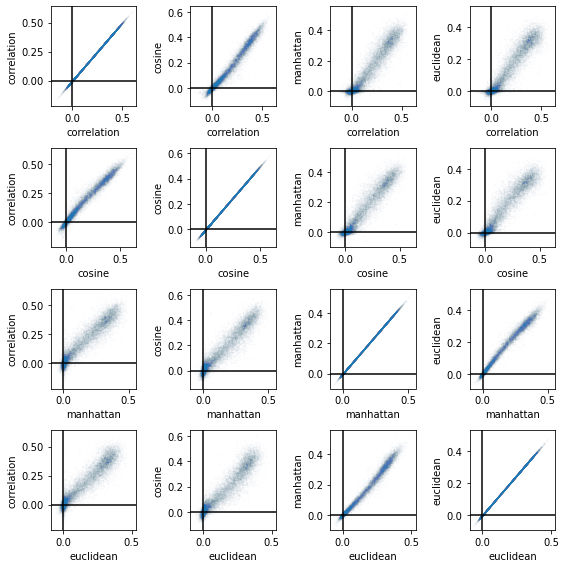

In [25]:
fig, axs = plt.subplots(ncols=4,nrows=4, figsize=(8,8))
for mi, metric in enumerate(metrics):
    for mi2, metric2 in enumerate(metrics):
        ax = axs[mi, mi2]
        ax.scatter(
            unit_statistics_df["categoricality_ALL_{}".format(metric)].values,
            unit_statistics_df["categoricality_ALL_{}".format(metric2)].values,
            s= 1,
            alpha = 0.01,
        )
        ax.set_xlabel(metric)
        ax.set_ylabel(metric2)
        ax.axvline(0, color = 'k')
        ax.axhline(0, color='k')
plt.tight_layout()

#### proportion nans

In [26]:
for metric in metrics:
    unit_statistics_df["prop_cs_nan_{}".format(metric)] = [
        np.mean(np.isnan(i))
        for i in unit_statistics_df["sm_{}_{}".format(metric, identifier)].values
    ]

In [27]:
nan_mask = (unit_statistics_df["prop_cs_nan_{}".format(metric)] > 0)   == False
np.mean(nan_mask), len(nan_mask), np.sum(nan_mask) 

(0.9616826322365681, 14406, 13854)

In [28]:
unit_statistics_df = unit_statistics_df[nan_mask]

### threshold

In [29]:
categoricality_thresh = 0.1

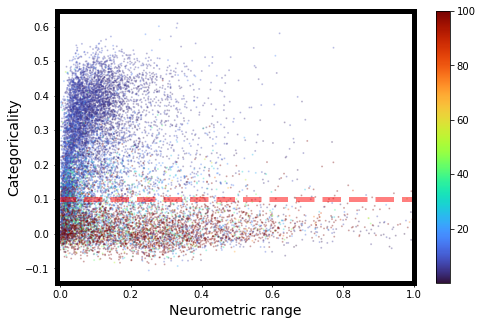

In [30]:
metric = 'cosine'
fig, ax = plt.subplots(figsize=(8,5))
scatter = ax.scatter(
    (unit_statistics_df["nm_range_{}_ALL".format(metric)].values.astype(float)),
    (unit_statistics_df["categoricality_ALL_{}".format(metric)].values.astype(float)),
    c=unit_statistics_df["nm_slope_{}_ALL".format(metric)],
    s=1,
    alpha=0.25,
    cmap="turbo",
)
ax.axhline(categoricality_thresh, color = 'red', ls = 'dashed', lw=5, alpha = 0.5)
ax.set_xlabel("Neurometric range", fontsize=14)
ax.set_ylabel("Categoricality", fontsize=14)
ax.set_xlim([-0.01,1])
cbar = plt.colorbar(scatter)
cbar.solids.set(alpha=1);
[i.set_linewidth(5) for i in ax.spines.values()];


In [31]:
categoricality_mask = (unit_statistics_df["categoricality_ALL_{}".format(metric)] > categoricality_thresh)  
np.mean(categoricality_mask), len(categoricality_mask), np.sum(categoricality_mask)

(0.5770174678793129, 13854, 7994)

In [32]:
good_units = (
    categoricality_mask
)

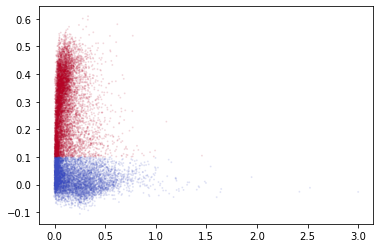

In [33]:
plt.scatter(
    (unit_statistics_df["nm_range_{}_ALL".format(metric)].values.astype(float)),
    (unit_statistics_df["categoricality_ALL_{}".format(metric)].values.astype(float)),
    c=good_units,
    s=1,
    alpha=0.1,
    cmap="coolwarm",
)

#### Show a random sample of categorical units

  0%|          | 0/200 [00:00<?, ?it/s]

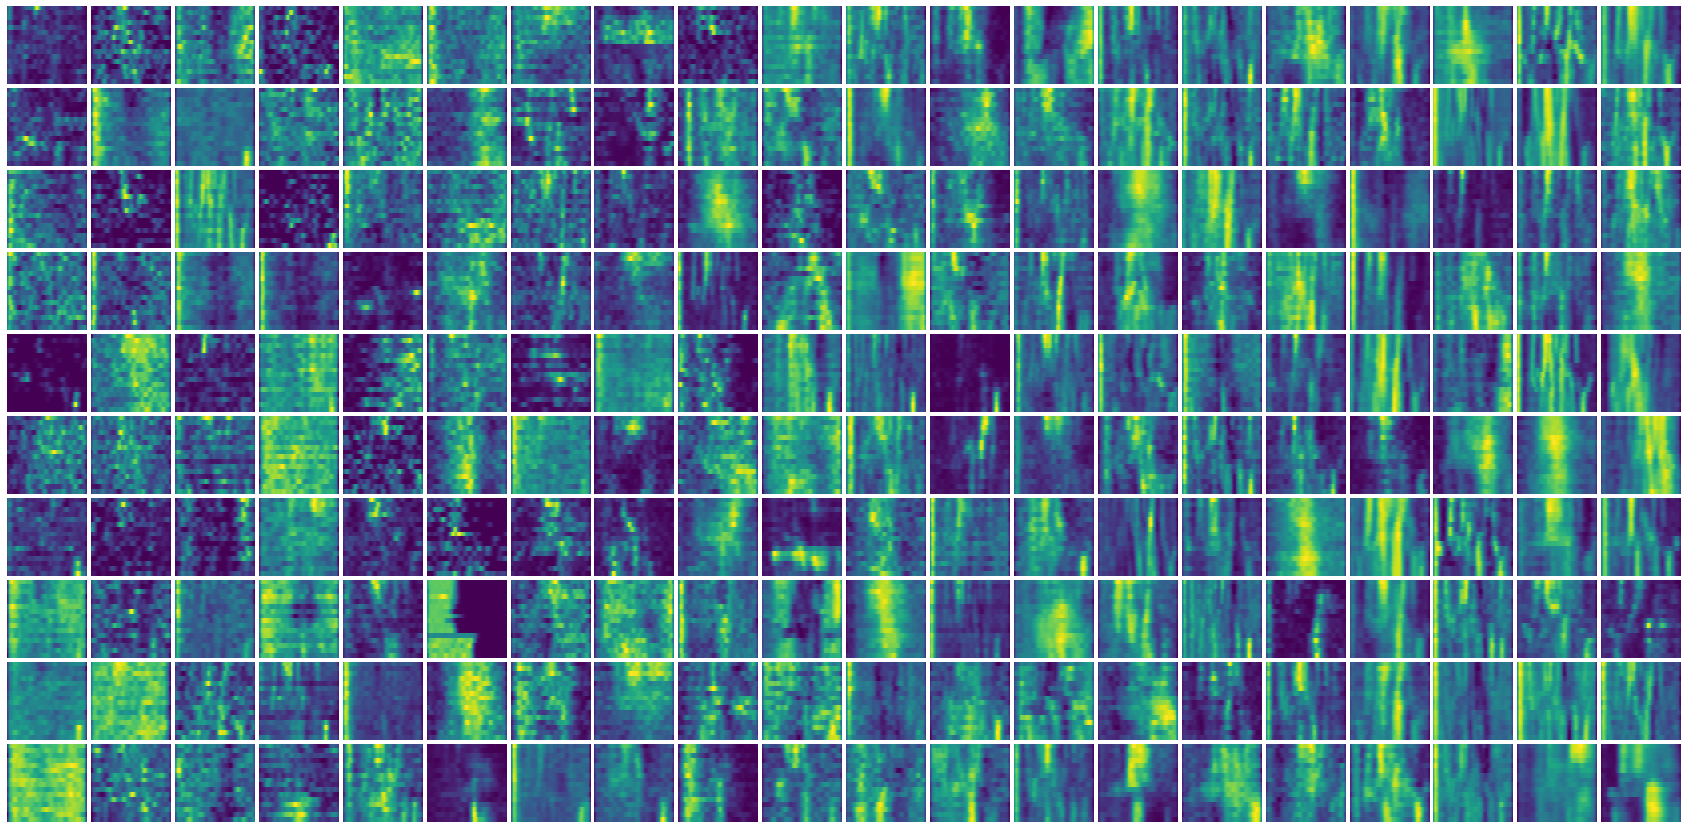

In [34]:
sort_param = "categoricality_ALL_{}".format('cosine')
sorted_unit_statistics_df = unit_statistics_df[good_units].sort_values(by=sort_param)
nrows = 10
ncols = 20
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(0, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row.rv_ALL
    rv = np.log(rv+1e-1)
    ax = axs.T.flatten()[i]
    try:
        ax.matshow(rv, aspect="auto")
    except:
        0
    ax.axis("off")

#### Show a random sample of noncategorial units

  0%|          | 0/200 [00:00<?, ?it/s]

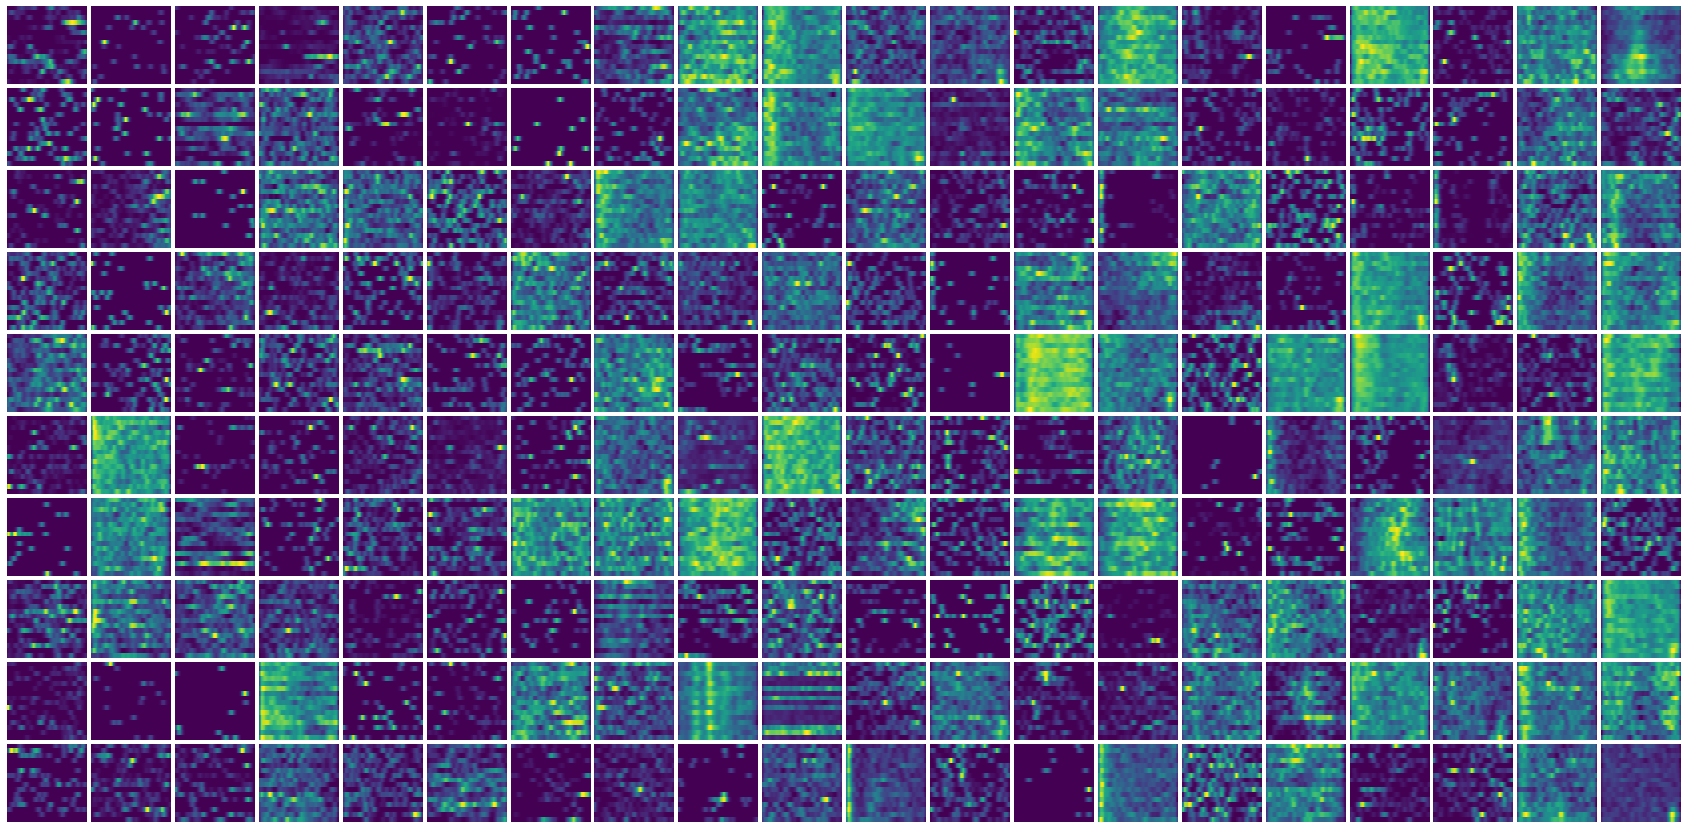

In [35]:
sort_param = "categoricality_ALL_{}".format('cosine')
sorted_unit_statistics_df = unit_statistics_df[good_units == False].sort_values(by=sort_param)
nrows = 10
ncols = 20
zoom = 1.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * zoom, nrows * zoom),
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
)
for i, ix in enumerate(tqdm(np.linspace(0, len(sorted_unit_statistics_df)-1, nrows*ncols).astype(int))):
    row = sorted_unit_statistics_df.iloc[ix]
    rv = row.rv_ALL
    rv = np.log(rv+1e-1)

    ax = axs.T.flatten()[i]
    try:
        ax.matshow(rv, aspect="auto")
    except:
        0
    ax.axis("off")

### save categorical units dataframe

In [36]:
unit_statistics_df['categorical_unit'] = good_units

In [37]:
unit_statistics_df['categoricality'] = unit_statistics_df["categoricality_ALL_{}".format('cosine')]

In [38]:
unit_statistics_df[['bird', 'unit', 'categorical_unit', 'categoricality']].to_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')

### Categorical unit stats

In [39]:
unit_statistics_df_good_units = unit_statistics_df[good_units]

In [40]:
birds, counts = np.unique(unit_statistics_df_good_units.bird.values, return_counts=True)
bird_good_units_counts = pd.DataFrame({
    'birds': birds,
    'counts': counts,
})
bird_good_units_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
birds,B1170,B1188,B1239,B1244,B1248,B1276,B1279,B1426,B1432,B1459,B1500,B1593,B1595,B1597
counts,467,214,129,123,1021,34,755,65,968,310,46,2054,45,1763


In [41]:
bird_good_units_counts

,birds,counts
0,B1170,467
1,B1188,214
2,B1239,129
3,B1244,123
4,B1248,1021
5,B1276,34
6,B1279,755
7,B1426,65
8,B1432,968
9,B1459,310


In [42]:
unit_statistics_df_good_units[:3]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,sm_correlation_AF,rv_AF,ips_AF,nm_min_correlation_AF,nm_max_correlation_AF,nm_r2_correlation_AF,nm_inflection_correlation_AF,nm_slope_correlation_AF,nm_range_correlation_AF,nm_scaled_slope_correlation_AF,sm_cosine_AF,nm_min_cosine_AF,nm_max_cosine_AF,nm_r2_cosine_AF,nm_inflection_cosine_AF,nm_slope_cosine_AF,nm_range_cosine_AF,nm_scaled_slope_cosine_AF,sm_euclidean_AF,nm_min_euclidean_AF,nm_max_euclidean_AF,nm_r2_euclidean_AF,nm_inflection_euclidean_AF,nm_slope_euclidean_AF,nm_range_euclidean_AF,nm_scaled_slope_euclidean_AF,sm_manhattan_AF,nm_min_manhattan_AF,nm_max_manhattan_AF,nm_r2_manhattan_AF,nm_inflection_manhattan_AF,nm_slope_manhattan_AF,nm_range_manhattan_AF,nm_scaled_slope_manhattan_AF,sm_correlation_AE,rv_AE,ips_AE,nm_min_correlation_AE,nm_max_correlation_AE,nm_r2_correlation_AE,nm_inflection_correlation_AE,nm_slope_correlation_AE,nm_range_correlation_AE,nm_scaled_slope_correlation_AE,sm_cosine_AE,nm_min_cosine_AE,nm_max_cosine_AE,nm_r2_cosine_AE,nm_inflection_cosine_AE,nm_slope_cosine_AE,nm_range_cosine_AE,nm_scaled_slope_cosine_AE,sm_euclidean_AE,nm_min_euclidean_AE,nm_max_euclidean_AE,nm_r2_euclidean_AE,nm_inflection_euclidean_AE,nm_slope_euclidean_AE,nm_range_euclidean_AE,nm_scaled_slope_euclidean_AE,sm_manhattan_AE,nm_min_manhattan_AE,nm_max_manhattan_AE,nm_r2_manhattan_AE,nm_inflection_manhattan_AE,nm_slope_manhattan_AE,nm_range_manhattan_AE,nm_scaled_slope_manhattan_AE,sm_correlation_BF,rv_BF,ips_BF,nm_min_correlation_BF,nm_max_correlation_BF,nm_r2_correlation_BF,nm_inflection_correlation_BF,nm_slope_correlation_BF,nm_range_correlation_BF,nm_scaled_slope_correlation_BF,sm_cosine_BF,nm_min_cosine_BF,nm_max_cosine_BF,nm_r2_cosine_BF,nm_inflection_cosine_BF,nm_slope_cosine_BF,nm_range_cosine_BF,nm_scaled_slope_cosine_BF,sm_euclidean_BF,nm_min_euclidean_BF,nm_max_euclidean_BF,nm_r2_euclidean_BF,nm_inflection_euclidean_BF,nm_slope_euclidean_BF,nm_range_euclidean_BF,nm_scaled_slope_euclidean_BF,sm_manhattan_BF,nm_min_manhattan_BF,nm_max_manhattan_BF,nm_r2_manhattan_BF,nm_inflection_manhattan_BF,nm_slope_manhattan_BF,nm_range_manhattan_BF,nm_scaled_slope_manhattan_BF,sm_correlation_BE,rv_BE,ips_BE,nm_min_correlation_BE,nm_max_correlation_BE,nm_r2_correlation_BE,nm_inflection_correlation_BE,nm_slope_correlation_BE,nm_range_correlation_BE,nm_scaled_slope_correlation_BE,sm_cosine_BE,nm_min_cosine_BE,nm_max_cosine_BE,nm_r2_cosine_BE,nm_inflection_cosine_BE,nm_slope_cosine_BE,nm_range_cosine_BE,nm_scaled_slope_cosine_BE,sm_euclidean_BE,nm_min_euclidean_BE,nm_max_euclidean_BE,nm_r2_euclidean_BE,nm_inflection_euclidean_BE,nm_slope_euclidean_BE,nm_range_euclidean_BE,nm_scaled_slope_euclidean_BE,sm_manhattan_BE,nm_min_manhattan_BE,nm_max_manhattan_BE,nm_r2_manhattan_BE,nm_inflection_manhattan_BE,nm_slope_manhattan_BE,nm_range_manhattan_BE,nm_scaled_slope_manhattan_BE,sm_correlation_CG,rv_CG,ips_CG,nm_min_correlation_CG,nm_max_correlation_CG,nm_r2_correlation_CG,nm_inflection_correlation_CG,nm_slope_correlation_CG,nm_range_correlation_CG,nm_scaled_slope_correlation_CG,sm_cosine_CG,nm_min_cosine_CG,nm_max_cosine_CG,nm_r2_cosine_CG,nm_inflection_cosine_CG,nm_slope_cosine_CG,nm_range_cosine_CG,nm_scaled_slope_cosine_CG,sm_euclidean_CG,nm_min_euclidean_CG,nm_max_euclidean_CG,nm_r2_euclidean_CG,nm_inflection_euclidean_CG,nm_slope_euclidean_CG,nm_range_euclidean_CG,nm_scaled_slope_euclidean_CG,sm_manhattan_CG,nm_min_manhattan_CG,nm_max_manhattan_CG,nm_r2_manhattan_CG,nm_inflection_manhattan_CG,nm_slope_manhattan_CG,nm_range_manhattan_CG,nm_scaled_slope_manhattan_CG,sm_correlation_AG,rv_AG,ips_AG,nm_min_correlation_AG,nm_max_correlation_AG,nm_r2_correlation_AG,nm_inflection_correlation_AG,nm_slope_correlation_AG,nm_range_correlation_AG,nm_scaled_slope_correlation_AG,sm_cosine_AG,nm_min_cosine_AG,nm_max_cosine_AG,nm_r2_cosine_AG,nm_inflection_cosine_AG,nm_slope_cosine_AG,nm_range_cosine_AG,nm_scaled_slope_cosine_

(1, 5000)

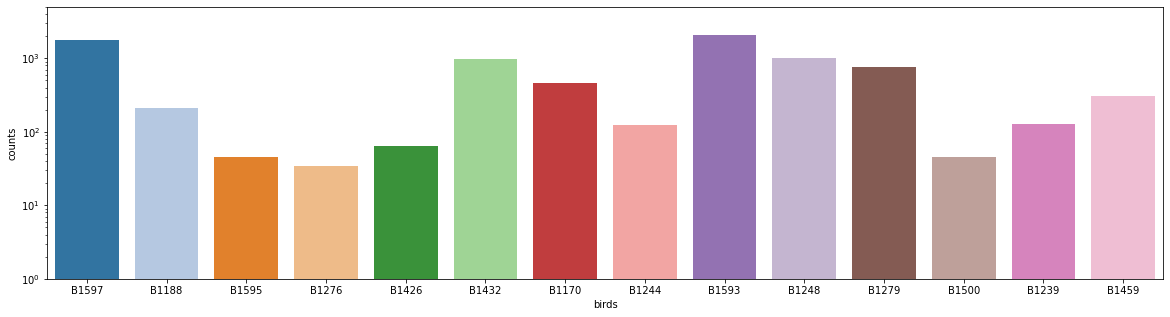

In [43]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x="birds", y="counts", data=bird_good_units_counts, palette='tab20', ax = ax, order = list(birds_df.index))
ax.set_yscale('log')
ax.set_ylim([1, 5000])

<AxesSubplot:xlabel='birds', ylabel='counts'>

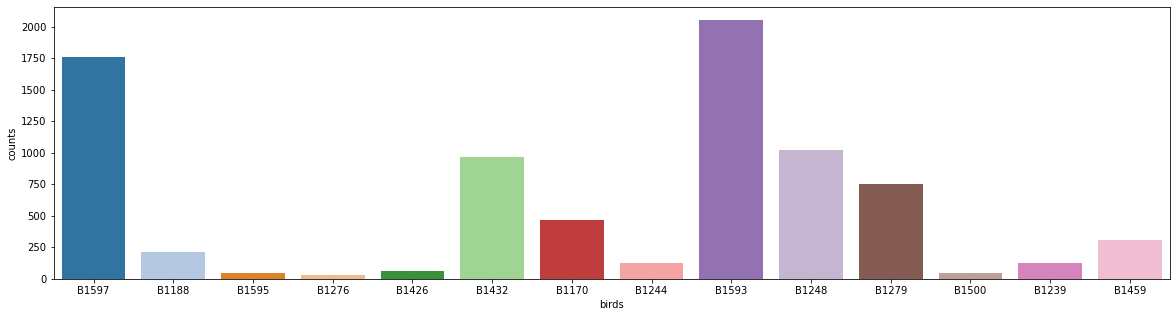

In [44]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x="birds", y="counts", data=bird_good_units_counts, palette='tab20', ax = ax, order = list(birds_df.index))

<AxesSubplot:xlabel='bird', ylabel='nm_range_cosine_ALL'>

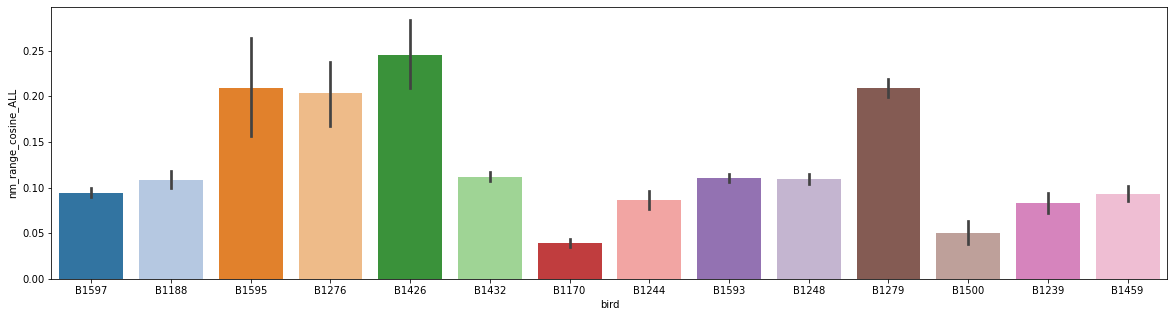

In [45]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x="bird", y="nm_range_{}_ALL".format(metric), data=unit_statistics_df_good_units, palette='tab20', ax = ax, order = list(birds_df.index))


In [46]:
print(f"Number of unit-spikes during playback {unit_statistics_df_good_units.n_spikes.sum():,}")

Number of unit-spikes during playback 576,987,582


In [47]:
print(f"Number of unit-passive-trials {unit_statistics_df_good_units.n_passive_trials.sum():,}")

Number of unit-passive-trials 42,573,962


In [48]:
print(f"Number of unit-active-trials {unit_statistics_df_good_units.n_active_trials.sum():,}")

Number of unit-active-trials 8,887,531


In [49]:
print(f"Number of unit-cued-trials {unit_statistics_df_good_units.n_cued_trials.sum():,}")

Number of unit-cued-trials 7,243,338


In [50]:
print(f"Number of good units {unit_statistics_df_good_units.categorical_unit.sum():,}")

Number of good units 7,994


In [51]:
###